<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Project/AE_mnist_superresolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning

In [6]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch import nn
import pytorch_lightning as pl


import numpy as np
import matplotlib.pyplot as plt


In [7]:
class AutoencoderSimple(pl.LightningModule):
    def __init__(self, encoder_linear_size=64):
        super(AutoencoderSimple, self).__init__()

        # Define the criterion
        self.criterion = nn.MSELoss()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(
            1, 6, kernel_size=3, stride=2, padding=1
        )  # Use stride 2 for downscaling
        self.encoder_conv2 = nn.Conv2d(
            6, 12, kernel_size=3, stride=2, padding=1
        )  # Use stride 2 for downscaling
        self.encoder_linear = nn.Linear(12 * 7 * 7, encoder_linear_size)

        # Decoder layers
        self.decoder_linear = nn.Linear(encoder_linear_size, 12 * 7 * 7)
        self.decoder_conv1 = nn.ConvTranspose2d(
            12, 6, kernel_size=3, stride=2, padding=1, output_padding=1
        )  # Use stride 2 for upscaling
        self.decoder_conv2 = nn.ConvTranspose2d(
            6, 1, kernel_size=3, stride=2, padding=1, output_padding=1
        )  # Use stride 2 for upscaling

    def encoder(self, x):
        # Encoder
        x = self.encoder_conv1(x)
        x = torch.relu(x)
        x = self.encoder_conv2(x)
        x = torch.relu(x)
        x = x.view(-1, 12 * 7 * 7)
        x = self.encoder_linear(x)
        return x

    def decoder(self, x):
        # Decoder
        x = self.decoder_linear(x)
        x = x.view(-1, 12, 7, 7)
        x = self.decoder_conv1(x)
        x = torch.relu(x)
        x = self.decoder_conv2(x)
        x = torch.sigmoid(x)
        return x

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, _ = batch
        outputs = self(images)
        loss = self.criterion(outputs, images)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, _ = batch
        outputs = self(images)
        loss = self.criterion(outputs, images)
        self.log("val_loss", loss)


In [ ]:
# Define the desired resolution
desired_resolution = (10, 10)  # Change this to your desired resolution

# Define transformations
transform = transforms.Compose([
    Resize(desired_resolution),
    ToTensor()
])

# Load the MNIST dataset with the defined transformations
mnist_reduced_size = MNIST(root='.', train=True, download=True, transform=transform)

In [27]:
# Check if pixel values are between 0 and 1
for i in range(len(mnist_reduced_size)):
    image, _ = mnist_reduced_size[i]
    if (image.min() < 0) or (image.max() > 1):
        print("Pixel values are not in the range [0, 1]")
        break
else:
    print("Pixel values are in the range [0, 1]")

Pixel values are in the range [0, 1]


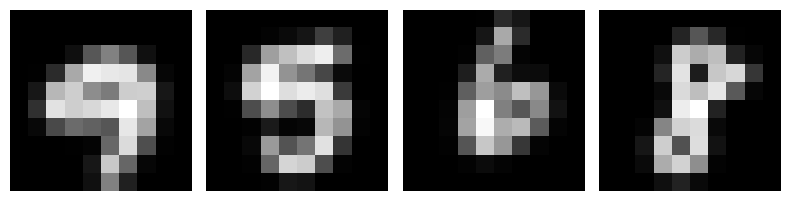

In [13]:
### plotting a  few images
# Extract 4 random images from the dataset
random_indices = np.random.randint(0, len(mnist_reduced_size), size=4)
images = [mnist_reduced_size[i][0] for i in random_indices]

# Plot the images
fig, axes = plt.subplots(1,4 , figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Creating dataloaders

In [16]:
# Split the dataset into train and validation sets
train_indices, val_indices = train_test_split(range(len(mnist_reduced_size)), test_size=0.2, random_state=42)

# Create train and validation subsets
train_dataset = Subset(mnist_reduced_size, train_indices)
val_dataset = Subset(mnist_reduced_size, val_indices)

# Create test dataset
test_dataset = MNIST(root='.', train=False, download=True, transform=transform)

In [21]:
# Check the shape of datasets
print("Train dataset shape:", len(train_dataset))
print("Validation dataset shape:", len(val_dataset))
print("Test dataset shape:", len(test_dataset))

# Extract one data point from each dataset
train_sample = train_dataset[0]  # Extract the first data point from the train dataset
val_sample = val_dataset[0]  # Extract the first data point from the validation dataset
test_sample = test_dataset[0]  # Extract the first data point from the test dataset

train_sample[0].shape

Train dataset shape: 48000
Validation dataset shape: 12000
Test dataset shape: 10000


torch.Size([1, 10, 10])

In [22]:
# Save the datasets
torch.save(train_dataset, 'train_dataset_mnist_low_res.pth')
torch.save(val_dataset, 'val_dataset_mnist_low_res.pth')
torch.save(test_dataset, 'test_dataset_mnist_low_res.pth')

In [28]:
# Define batch size
batch_size = 64

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### code for training and validation

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, print_epoch=1, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        for batch_idx, batch in enumerate(train_loader):
            loss = model.training_step(batch, batch_idx)
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        if epoch % print_epoch == 0:
            print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                loss = model.validation_step(batch, batch_idx)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if epoch % print_epoch == 0:
            print(f"Epoch {epoch}/{num_epochs}, Validation Loss: {val_loss:.4f}")

    return train_losses, val_losses
